In [1]:
#import necessary packages
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import geopy
from geopy.geocoders import Nominatim

In [2]:
#load the data files
house = pd.read_csv('./input/raw_house_data.csv')

In [3]:
#code to explore first few rows of data
house.head()

,MLS,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,sqrt_ft,garage,kitchen_features,fireplaces,floor_covering,HOA
0,21530491,5300000.0,85637,-110.378200,31.356362,2154.00,5272.00,1941,13,10,10500,0,"Dishwasher, Freezer, Refrigerator, Oven",6,"Mexican Tile, Wood",0
1,21529082,4200000.0,85646,-111.045371,31.594213,1707.00,10422.36,1997,2,2,7300,0,"Dishwasher, Garbage Disposal",5,"Natural Stone, Other",0
2,3054672,4200000.0,85646,-111.040707,31.594844,1707.00,10482.00,1997,2,3,None,None,"Dishwasher, Garbage Disposal, Refrigerator",5,"Natural Stone, Other: Rock",None
3,21919321,4500000.0,85646,-111.035925,31.645878,636.67,8418.58,1930,7,5,9019,4,"Dishwasher, Double Sink, Pantry: Butler, Refri...",4,"Ceramic Tile, Laminate, Wood",None
4,21306357,3411450.0,85750,-110.813768,32.285162,3.21,15393.00,1995,4,6,6396,3,"Dishwasher, Garbage Disposal, Refrigerator, Mi...",5,"Carpet, Concrete",55


In [4]:
house.shape

(5000, 16)

In [4]:
# code to fill empty spaces with NaN for modification to something that can later be manipulated.
house = house.replace(r'^\s*$', np.nan, regex=True)

In [5]:
# convert columns with input as "None", to NaN.
col_none = list(house.columns)
house = house[col_none].replace(['None'], np.nan, regex=True)

In [6]:
# convert some object columns to numerical types
cols = ['sqrt_ft', 'garage', 'bathrooms', 'fireplaces']
house[cols] = house[cols].astype('float')
house.dtypes

MLS                   int64
sold_price          float64
zipcode               int64
longitude           float64
latitude            float64
lot_acres           float64
taxes               float64
year_built            int64
bedrooms              int64
bathrooms           float64
sqrt_ft             float64
garage              float64
kitchen_features     object
fireplaces          float64
floor_covering       object
HOA                  object
dtype: object

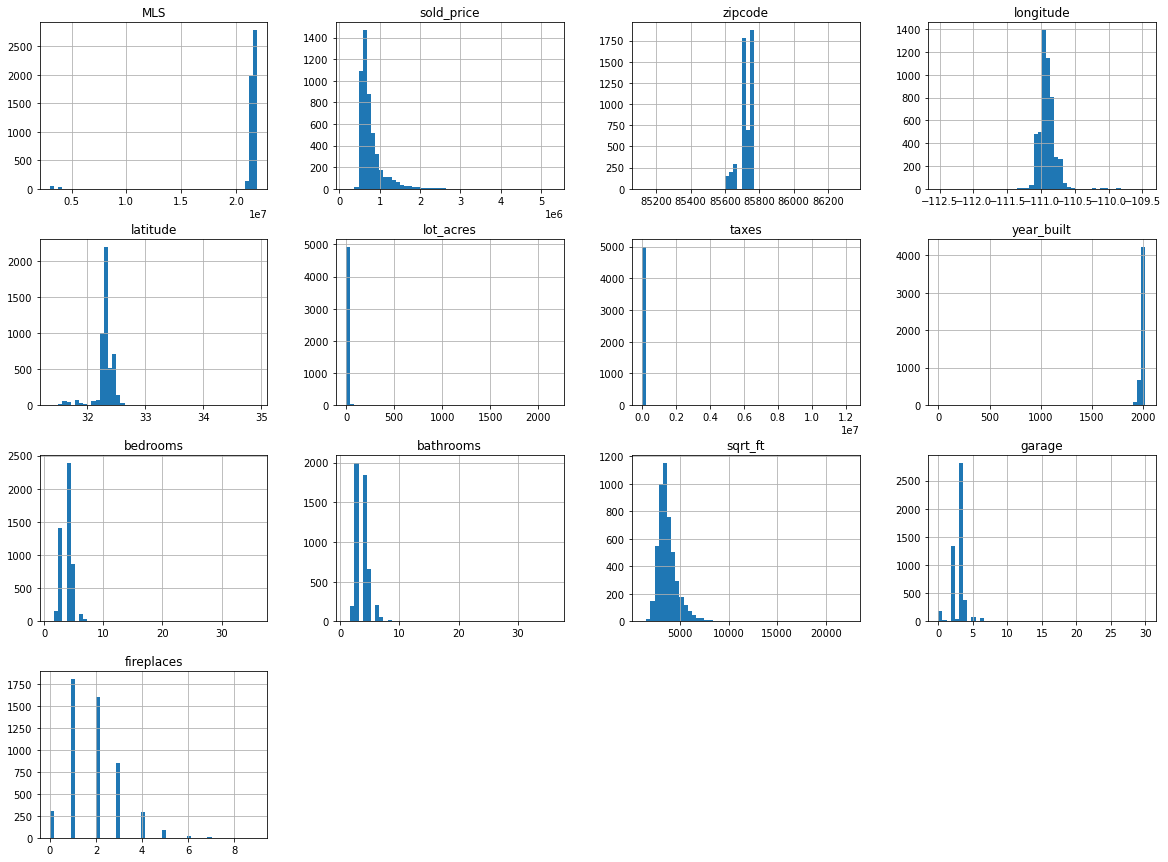

In [7]:
# distribution of all the variables
house.hist(bins=50,figsize=(20,15))
plt.show()

In [8]:
#since all the columns with missing data were skewed, with a tail, I used Mode to impute values
house['lot_acres'] = house['lot_acres'].fillna(house['lot_acres'].mode()[0])
house['sqrt_ft'] = house['sqrt_ft'].fillna(house['sqrt_ft'].mode()[0])
house['fireplaces'] = house['fireplaces'].fillna(house['fireplaces'].mode()[0])
house['garage'] = house['garage'].fillna(house['garage'].mode()[0])
house['bathrooms'] = house['bathrooms'].fillna(house['bathrooms'].mode()[0])

In [9]:
#create new column for calculating house age to date given year built
current_year = datetime.datetime.now().year
house['current_year'] = datetime.datetime.now().year
house["house_age"] = house['current_year'] - house['year_built']

In [10]:
# temporary copy of house data
X = house.copy()

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MLS               5000 non-null   int64  
 1   sold_price        5000 non-null   float64
 2   zipcode           5000 non-null   int64  
 3   longitude         5000 non-null   float64
 4   latitude          5000 non-null   float64
 5   lot_acres         5000 non-null   float64
 6   taxes             5000 non-null   float64
 7   year_built        5000 non-null   int64  
 8   bedrooms          5000 non-null   int64  
 9   bathrooms         5000 non-null   float64
 10  sqrt_ft           5000 non-null   float64
 11  garage            5000 non-null   float64
 12  kitchen_features  4967 non-null   object 
 13  fireplaces        5000 non-null   float64
 14  floor_covering    4998 non-null   object 
 15  HOA               4438 non-null   object 
 16  current_year      5000 non-null   int64  


In [12]:
# extract names of all categorical columns('Object')
object_cols = [col for col in X.columns if X[col].dtype == "object"]

In [13]:
# drop all object columns that have been proved not useful
X.drop(object_cols, axis=1, inplace=True)
X.drop('current_year', axis=1, inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MLS         5000 non-null   int64  
 1   sold_price  5000 non-null   float64
 2   zipcode     5000 non-null   int64  
 3   longitude   5000 non-null   float64
 4   latitude    5000 non-null   float64
 5   lot_acres   5000 non-null   float64
 6   taxes       5000 non-null   float64
 7   year_built  5000 non-null   int64  
 8   bedrooms    5000 non-null   int64  
 9   bathrooms   5000 non-null   float64
 10  sqrt_ft     5000 non-null   float64
 11  garage      5000 non-null   float64
 12  fireplaces  5000 non-null   float64
 13  house_age   5000 non-null   int64  
dtypes: float64(9), int64(5)
memory usage: 547.0 KB


In [14]:
#create price per square foot category column to make the price category column
X["price_per_sqft"]=X["sold_price"]/X["sqrt_ft"]

In [15]:
# function to floor input divided by 100
def bin_func(val):
    return (val//100)

In [16]:
# Create price category column to be used in model
X["price_cat"] = bin_func(X["price_per_sqft"])

In [17]:
# check added columns
X.columns

Index(['MLS', 'sold_price', 'zipcode', 'longitude', 'latitude', 'lot_acres',
       'taxes', 'year_built', 'bedrooms', 'bathrooms', 'sqrt_ft', 'garage',
       'fireplaces', 'house_age', 'price_per_sqft', 'price_cat'],
      dtype='object')

In [18]:
# Correlation table for the zipcode against other columns
corr_matrix=X.corr()
corr_matrix.zipcode.sort_values(ascending=False)

zipcode           1.000000
latitude          0.457102
MLS               0.323165
garage            0.081066
bedrooms          0.049982
longitude         0.049399
year_built        0.037776
taxes            -0.001265
sqrt_ft          -0.003710
fireplaces       -0.007104
house_age        -0.037776
price_cat        -0.039149
sold_price       -0.039925
bathrooms        -0.050670
price_per_sqft   -0.062821
lot_acres        -0.126539
Name: zipcode, dtype: float64

(0.0, 3.0)

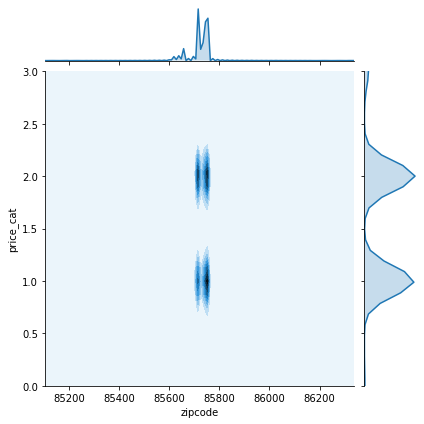

In [19]:
#distribution plot comparing how zipcode relates with price category
sns.jointplot(x=X['zipcode'], y=X['price_cat'], kind="kde",)
plt.ylim(0, 3)

Skewness: -1.596696
Kurtosis: 34.413434


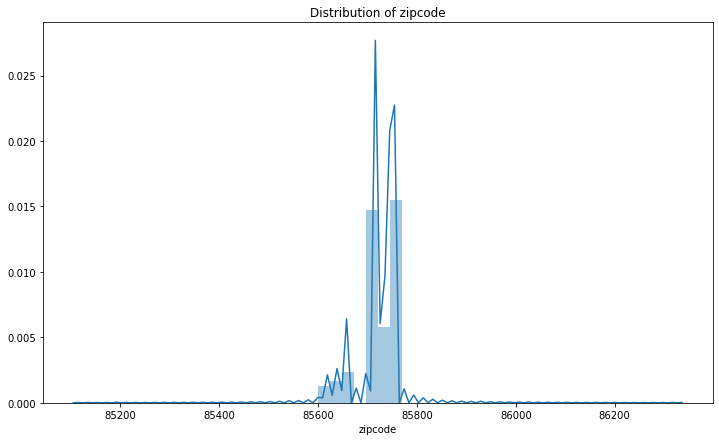

In [20]:
plt.figure(figsize=(12,7))

# distribution of the target variable
sns.distplot(X['zipcode']);

# plot title
plt.title("Distribution of zipcode")
#skewness and kurtosis
print("Skewness: %f" % X['zipcode'].skew())
print("Kurtosis: %f" % X['zipcode'].kurt())

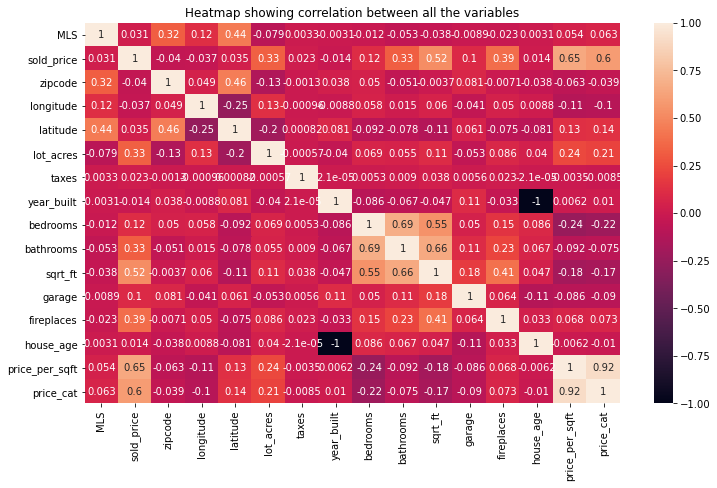

In [21]:
# Heatmap showing the correlation between the different data sets. 
# Set the width and height of the figure
plt.figure(figsize=(12,7))

# Add title
plt.title("Heatmap showing correlation between all the variables")

# Add label for horizontal axis
plt.xlabel("Variables")
plt.ylabel("Variables")

sns.heatmap(X.corr(), annot=True)

In [22]:
# create definitions for the KNN Classifier model

# define prediction target
full_y = X["price_cat"].to_numpy(int)

# define training variables
cols = ['longitude','latitude']
full_X = X[cols]

In [23]:
# exploring shape of the MODEL inputs
print(full_X.shape, full_y.shape)

(5000, 2) (5000,)


In [24]:
#defining the Train, Validate, Split for model inputs

# prediction variables split
train_X = full_X.iloc[:3000,].values
hold = full_X.iloc[3000:,].values
val_X = hold[:1000,]
test_X = hold[1000:,]

# prediction Target split
train_y =full_y[:3000,]
holder =full_y[3000:]
val_y = holder[:1000,]
test_y = holder[1000:,]

In [25]:
# check dimensions of new jewellery set
train_X.shape, val_X.shape, test_X.shape, train_y.shape, val_y.shape, test_y.shape

((3000, 2), (1000, 2), (1000, 2), (3000,), (1000,), (1000,))

## KNN CLASSIFIER MODEL

In [26]:
class KNNClassifier():
    def fit(self, X,y):
        self.X = X
        self.y = y 
        
    def predict(self, X,K, epsilon=1e-3):
        N = len(X)
        y_hat = np.zeros(N)
        
        for i in range(N):
            dist2 = np.sum((self.X-X[i])**2, axis=1)
            idxt = np.argsort(dist2)[:K]
            gamma_k = 1/(np.sqrt(dist2[idxt])+ epsilon)
            y_hat[i] = np.bincount(self.y[idxt], weights= gamma_k).argmax()
            
        return y_hat

In [27]:
knn = KNNClassifier()
knn.fit(train_X, train_y)


In [28]:
y_hat = knn.predict(val_X, 17)

In [29]:
def accuracy(y, y_hat):
    return np.mean(y==y_hat)

In [30]:
accuracy(val_y, y_hat)

0.547

In [31]:
y_hat = knn.predict(test_X, 21)

In [32]:
accuracy(test_y, y_hat)

0.517

## KNN REGRESSION MODEL

In [33]:
X.head()

,MLS,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,sqrt_ft,garage,fireplaces,house_age,price_per_sqft,price_cat
0,21530491,5300000.0,85637,-110.378200,31.356362,2154.00,5272.00,1941,13,10.0,10500.0,0.0,6.0,79,504.761905,5.0
1,21529082,4200000.0,85646,-111.045371,31.594213,1707.00,10422.36,1997,2,2.0,7300.0,0.0,5.0,23,575.342466,5.0
2,3054672,4200000.0,85646,-111.040707,31.594844,1707.00,10482.00,1997,2,3.0,3541.0,3.0,5.0,23,1186.105620,11.0
3,21919321,4500000.0,85646,-111.035925,31.645878,636.67,8418.58,1930,7,5.0,9019.0,4.0,4.0,90,498.946668,4.0
4,21306357,3411450.0,85750,-110.813768,32.285162,3.21,15393.00,1995,4,6.0,6396.0,3.0,5.0,25,533.372420,5.0


In [34]:
#List unique values in the df['name'] column
#df.name.unique()
X.price_cat.unique()

array([ 5., 11.,  4.,  1.,  2.,  7.,  3.,  9.,  8.,  6.,  0., 12.])

In [35]:
# Normalization functions
def normalize(dataset):
    dataNorm=((dataset-dataset.min())/(dataset.max()-dataset.min()))
    return dataNorm

def normal(dataset,orgdata):
    dataNorm=((dataset-orgdata.min())/(orgdata.max()-orgdata.min()))
    return dataNorm

def revert(normdata,orgdata):
    revNorm = ((normdata)*(orgdata.max()-orgdata.min())) + orgdata.min()
    return revNorm

In [36]:
X_B = normalize(X)
X_B.shape

(5000, 16)

In [37]:
X_B.sample(5)

,MLS,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,sqrt_ft,garage,fireplaces,house_age,price_per_sqft,price_cat
99,0.972668,0.288638,0.448133,0.483964,0.307819,0.001927,0.001527,0.995047,0.057143,0.085714,0.203679,0.100000,0.333333,0.004953,0.235485,0.250000
2018,0.994086,0.110992,0.515353,0.520160,0.308591,0.002321,0.001192,0.991085,0.057143,0.057143,0.300122,0.133333,0.333333,0.008915,0.062501,0.000000
4441,0.957583,0.069382,0.507884,0.574061,0.226869,0.000576,0.000641,0.992075,0.085714,0.057143,0.160175,0.200000,0.222222,0.007925,0.077536,0.083333
4952,0.989302,0.070357,0.515353,0.541190,0.334106,0.000135,0.000368,0.993561,0.028571,0.057143,0.070349,0.100000,0.111111,0.006439,0.151530,0.166667
4778,0.999260,0.073280,0.517842,0.490179,0.294053,0.000097,0.000499,0.999009,0.085714,0.057143,0.091280,0.100000,0.000000,0.000991,0.130460,0.083333


In [38]:
col = ['garage','bedrooms', 'house_age', 'price_cat']
X_full = X_B[col].to_numpy()
y_full = X_B["zipcode"].to_numpy(dtype='int64')

print(y_full)

# test
datt = X_full[:,2]
print(datt[0:10])

[0 0 0 ... 0 0 0]
[0.03863299 0.01089648 0.01089648 0.04408123 0.01188707 0.00990589
 0.0089153  0.00396236 0.00842001 0.00594354]


In [39]:
#defining the Train, Validate, Split for model inputs

# prediction variables split
X_train = X_full[:3000,]
hld = X_full[3000:]
X_val = hld[:1000,]
X_test = hld[1000:,]

# prediction target split
y_train = y_full[:3000,]
holdem = y_full[3000:,]
y_val = holdem[:1000,]
y_test = holdem[1000:,]

In [40]:
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(3000, 4) (1000, 4) (1000, 4) (3000,) (1000,) (1000,)


In [41]:
class KNNRegressor():
    def fit(self,X,y):
        self.X = X
        self.y = y
        
    def predict(self,X, K, epsilon=1e-03):
        N = len(X)
        y_hat = np.zeros(N)
        
        for i in range(N):
            dist2 = np.sum((self.X-X[i])**2,axis=1)
            idxt = np.argsort(dist2)[:K]
            gamma_k = 1/(np.sqrt(dist2[idxt]) + epsilon)
            y_hat[i] = gamma_k.dot(self.y[idxt])/gamma_k.sum() #traget value with the height weight
             
        return y_hat

In [42]:
kinr = KNNRegressor()

In [43]:
kinr.fit(X_train, y_train)

In [44]:
y_hatr = kinr.predict(X_val,300, epsilon=1e-3)

In [45]:
accuracy(y_val, y_hatr)

0.996

In [46]:
y_hatr2 = kinr.predict(X_test, 300, epsilon=1e-3)

In [47]:
accuracy(y_test, y_hatr2)

0.997

## TEST DEPLOYMENT

In [51]:
#client inputs/specifications
garage = 2
bedrooms = 1
house_age = 50
price_cat = 7

# store inputs in list
clnt = [garage, bedrooms, house_age, price_cat]


XB = normal(clnt, X_full)
#XB.shape

out = kinr.predict(XB, 300, epsilon=1e-3)
result = revert(out, X_full)

result

array([0., 0., 0., 0.])